# Anomaly Detection

In [2]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [64]:
import json
import os
from pathlib import Path
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set_palette("Set2", 8, .75)

<IPython.core.display.Javascript object>

# Tweet Volumes

In [4]:
DATADIR = Path("data/")

realTweets = DATADIR / "realTweets" / "realTweets"

<IPython.core.display.Javascript object>

In [5]:
fpath = realTweets / f"Twitter_volume_GOOG.csv"

df = pd.read_csv(fpath)
df.head()

timestamp  value
0  2015-02-26 21:42:53     35
1  2015-02-26 21:47:53     41
2  2015-02-26 21:52:53     32
3  2015-02-26 21:57:53     36
4  2015-02-26 22:02:53     32

<IPython.core.display.Javascript object>

In [6]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15842 entries, 0 to 15841
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   timestamp  15842 non-null  object
 1   value      15842 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 247.7+ KB
None


<IPython.core.display.Javascript object>

In [7]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

<IPython.core.display.Javascript object>

In [8]:
print(df['value'].mean())

20.736396919580862


<IPython.core.display.Javascript object>

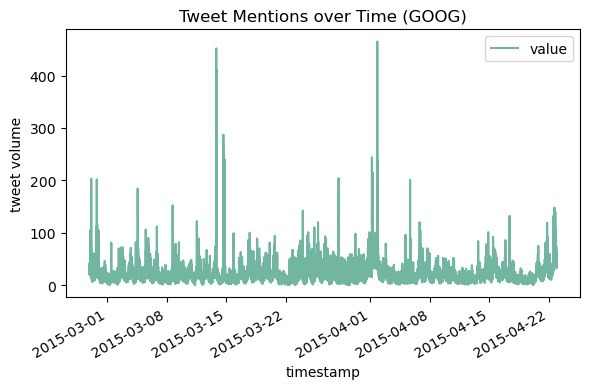

<IPython.core.display.Javascript object>

In [28]:
fig, ax = plt.subplots(dpi=100)
df.plot(x='timestamp', y='value', ax=ax)
ax.set(ylabel='tweet volume', title='Tweet Mentions over Time (GOOG)')
fig.tight_layout();

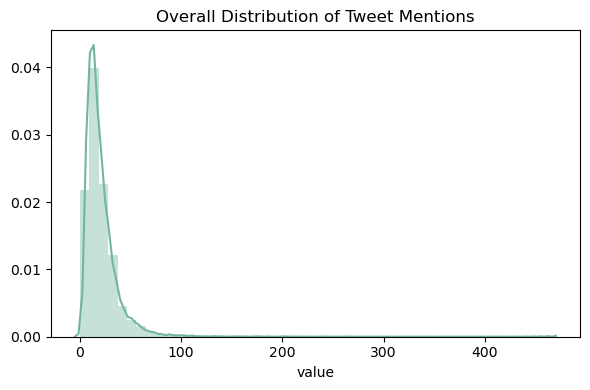

<IPython.core.display.Javascript object>

In [161]:
fig, ax = plt.subplots(dpi=100)
sns.distplot(df['value'], ax=ax)
ax.set(title='Overall Distribution of Tweet Mentions')
fig.tight_layout();

## Examining Autocorrelation and Seasonality of Data

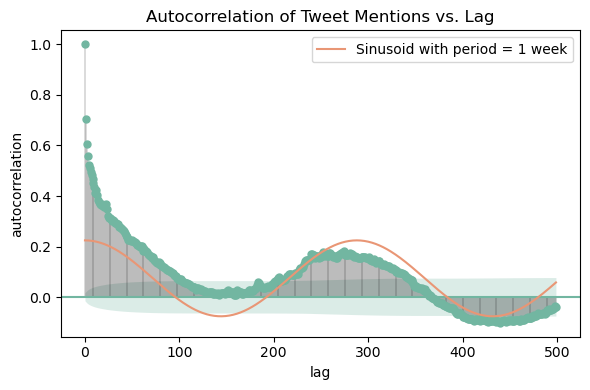

<IPython.core.display.Javascript object>

In [159]:
import statsmodels.api as sm

lags = np.arange(0, 500)
MINS_PER_DAY = 24 * 60
MINS_PER_ENTRY = 5
week_sine = 0.15 * np.cos((2*np.pi * MINS_PER_ENTRY * lags / MINS_PER_DAY)) + 0.075

fig, ax = plt.subplots(dpi=100)
sm.graphics.tsa.plot_acf(df['value'], lags=max(lags), ax=ax, vlines_kwargs={'linewidth':0.2})
sns.lineplot(lags, week_sine, ax=ax, label='Sinusoid with period = 1 week')
ax.set(xlabel='lag', ylabel='autocorrelation', title='Autocorrelation of Tweet Mentions vs. Lag')
ax.legend()
fig.tight_layout();

In [83]:
# the hours and if it's night or day (7:00-22:00)
df['hours'] = df['timestamp'].dt.hour
df['daylight'] = ((df['hours'] >= 7) & (df['hours'] <= 22)).astype(int)

<IPython.core.display.Javascript object>

In [84]:
# the day of the week (Monday=0, Sunday=6) and if it's a weekday (0) or weekend day (1).
df['DayOfTheWeek'] = df['timestamp'].dt.dayofweek
df['WeekDay'] = (df['DayOfTheWeek'] < 5).astype(int)

<IPython.core.display.Javascript object>

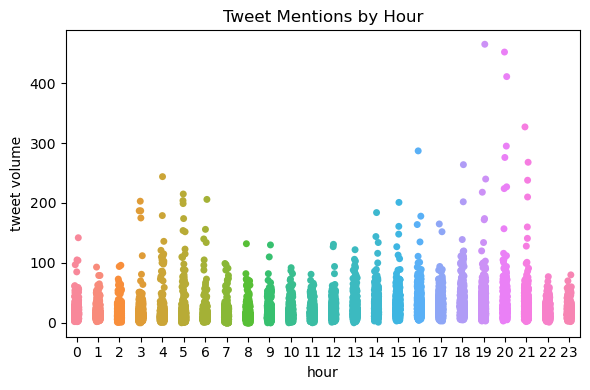

<IPython.core.display.Javascript object>

In [85]:
fig, ax = plt.subplots(dpi=100)
sns.stripplot(x='hours', y='value', data=df, ax=ax)
ax.set(xlabel='hour', ylabel='tweet volume', title='Tweet Mentions by Hour')
fig.tight_layout();

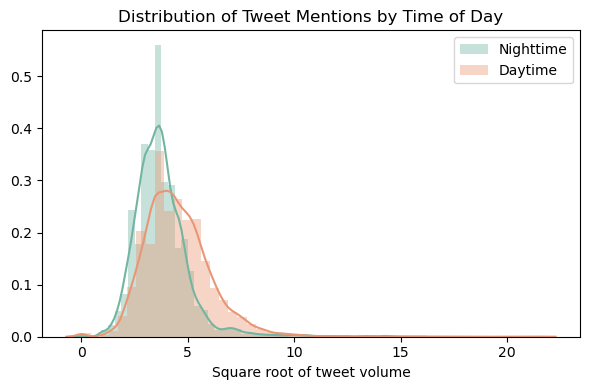

<IPython.core.display.Javascript object>

In [157]:
fig, ax = plt.subplots(dpi=100)
sns.distplot(np.sqrt(df.loc[df['daylight'] == 0]['value']), ax=ax, label='Nighttime')
sns.distplot(np.sqrt(df.loc[df['daylight'] == 1]['value']), ax=ax, label='Daytime')
ax.set(xlabel='Square root of tweet volume', title='Distribution of Tweet Mentions by Time of Day')
ax.legend();
fig.tight_layout();

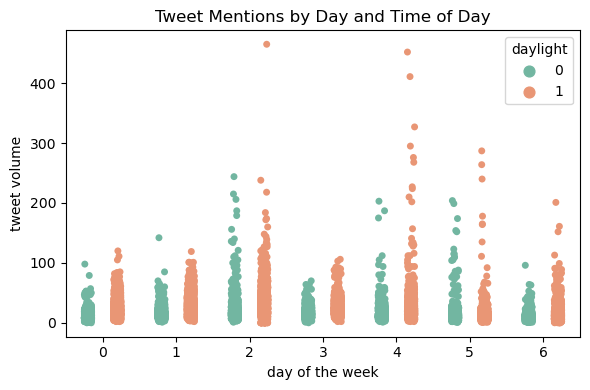

<IPython.core.display.Javascript object>

In [86]:
fig, ax = plt.subplots(dpi=100)
sns.stripplot(x='DayOfTheWeek', y='value', hue='daylight', data=df, dodge=True, ax=ax)
ax.set(xlabel='day of the week', ylabel='tweet volume', title='Tweet Mentions by Day and Time of Day')
fig.tight_layout();

## Models

### Naive K-means

In [87]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

data = df[['value', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
min_max_scaler = StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)

# reduce to 2 importants features
pca = PCA(n_components=2)
data = pca.fit_transform(data)

# standardize these 2 new features
min_max_scaler = StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)

<IPython.core.display.Javascript object>

In [88]:
ks = np.arange(1, 20)
seeds = tuple(range(1, len(ks)+1))
scores = np.empty(ks.shape)
for i, k in enumerate(tqdm(ks)):
    seed = seeds[i]
    kmeans = KMeans(n_clusters=k, random_state=seed)
    kmeans.fit(data)
    
    scores[i] = kmeans.score(data)

100%|██████████| 19/19 [00:18<00:00,  1.01it/s]


<IPython.core.display.Javascript object>

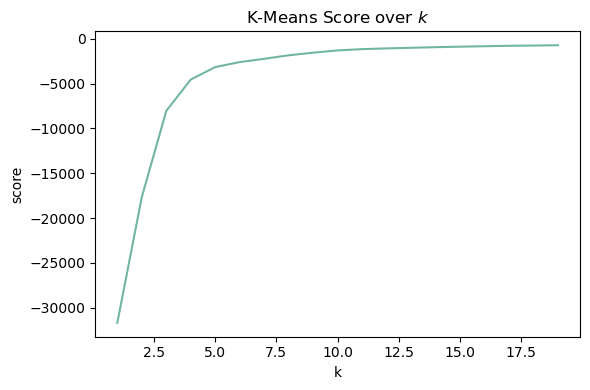

<IPython.core.display.Javascript object>

In [89]:
fig, ax = plt.subplots(dpi=100)
sns.lineplot(ks, scores, ax=ax)
ax.set(xlabel='k', ylabel='score', title=r'K-Means Score over $k$')
fig.tight_layout();